In [31]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

## Importing data set 

In [32]:
readRDS = robjects.r['readRDS']
df = readRDS('loan_data.rds')
df = pandas2ri.ri2py(df)

## Describing data set 

In [33]:
df.describe(include=[np.object])

,grade,home_ownership,emp_cat,ir_cat
count,29091,29091,29091,29091
unique,7,4,5,5
top,A,RENT,0-15,0-8
freq,9649,14692,25642,7130


In [34]:
df.describe(include=[np.number])

,loan_status,loan_amnt,annual_inc,age
count,29091.000000,29091.000000,2.909100e+04,29091.000000
mean,0.110928,9593.663848,6.696489e+04,27.698120
std,0.314048,6323.467488,5.325318e+04,6.194617
min,0.000000,500.000000,4.000000e+03,20.000000
25%,0.000000,5000.000000,4.000000e+04,23.000000
50%,0.000000,8000.000000,5.640000e+04,26.000000
75%,0.000000,12250.000000,8.000000e+04,30.000000
max,1.000000,35000.000000,2.039784e+06,94.000000


In [35]:
l = df.select_dtypes(exclude=[object]).shape[1]
n = int(np.floor(np.sqrt(l)))
m = int(np.ceil(l / n))

<IPython.core.display.Javascript object>


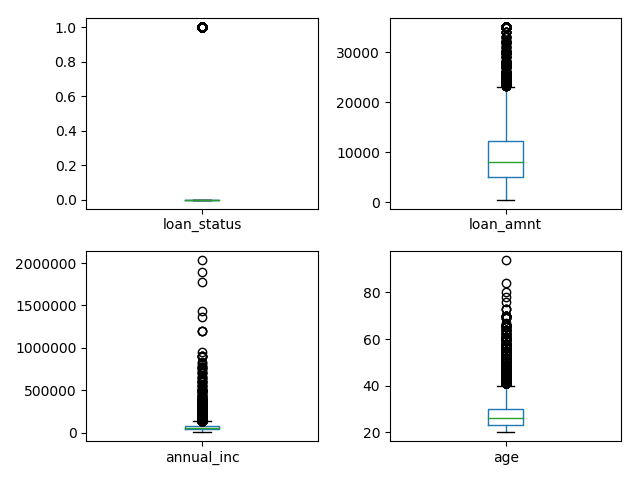

In [36]:
f, ax = plt.subplots(n,m)
ax = ax.flatten()
i = 0
for col in df.select_dtypes(exclude=[object]).iteritems():
    col[1].plot(kind='box', ax = ax[i])
    i = i + 1
plt.tight_layout()

In [38]:
df.groupby("loan_status").aggregate([np.mean, np.std])

loan_amnt                 annual_inc                      age  \
                    mean          std          mean           std       mean   
loan_status                                                                    
0            9619.234264  6307.620056  67937.626557  54029.038933  27.733955   
1            9388.720174  6446.406294  59168.548119  45837.568727  27.410908   

                       
                  std  
loan_status            
0            6.208826  
1            6.072846

In [39]:
table = pd.crosstab(df["grade"], df["loan_status"], normalize=True)
#table.div(table.sum(1), axis=0).plot(kind='bar', stacked=True)

## Getting dummy variables

In [107]:
df = pd.get_dummies(df)

In [108]:
df.columns

Index(['loan_status', 'loan_amnt', 'annual_inc', 'age', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'emp_cat_0-15', 'emp_cat_15-30', 'emp_cat_30-45',
       'emp_cat_45+', 'emp_cat_Missing', 'ir_cat_0-8', 'ir_cat_11-13.5',
       'ir_cat_13.5+', 'ir_cat_8-11', 'ir_cat_Missing'],
      dtype='object')

In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [196]:
target = ["loan_status"]
features = [x for x in list(df.columns) if x not in target]

In [197]:
model = LogisticRegression()

In [207]:
X = df[features]
y = np.ravel(df[target])
rfe = RFE(model, 13)
rfe.fit(X, y)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=13, step=1, verbose=0)

In [208]:
X = X[X.columns[rfe.get_support()]]

In [209]:
X.columns

Index(['grade_A', 'grade_B', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'emp_cat_0-15', 'emp_cat_15-30', 'emp_cat_30-45', 'ir_cat_0-8'],
      dtype='object')

### Analysing p-values

In [273]:
import statsmodels.api as sm
logit_model = sm.Logit(y, X)
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.335575
         Iterations 7


In [274]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
========================================================================
Model:                Logit              Pseudo R-squared:   0.037      
Dependent Variable:   y                  AIC:                19550.3956 
Date:                 2018-05-20 00:28   BIC:                19658.0120 
No. Observations:     29091              Log-Likelihood:     -9762.2    
Df Model:             12                 LL-Null:            -10137.    
Df Residuals:         29078              LLR p-value:        1.3054e-152
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       7.0000                                            
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
grade_A                 -0.7479   0.0836  -8.9492 0.0000 -0.9117 -0.5841
grade_B                 -0.3910   0.0499  -7.8301 0.0000 -0.4889 -0.2931
grade_D                  0.2301   0.0589   3.9082 0.0001  0.1147  0.3455
grade_E                  0.3876   0.0923   4.2015 0.0000  0.2068  0.5685
grade_F                  0.7350   0.1607   4.5743 0.0000  0.4201  1.0499
grade_G                  1.2772   0.2787   4.5820 0.0000  0.7309  1.8235
home_ownership_MORTGAGE -0.9366   0.0926 -10.1200 0.0000 -1.1180 -0.7552
home_ownership_OWN      -0.9005   0.1062  -8.4758 0.0000 -1.1087 -0.6923
home_ownership_RENT     -0.8273   0.0905  -9.1448 0.0000 -1.0046 -0.6500
emp_cat_0-15            -0.9139   0.0855 -10.6948 0.0000 -1.0814 -0.7464
emp_cat_15-30           -0.8300   0.1067  -7.7758 0.0000 -1.0392 -0.6208
emp_cat_30-45           -1.2163   0.2544  -4.7809 0.0000 -1.7149 -0.7177
ir_cat_0-8              -0.4102   0.0919  -4.4621 0.0000 -0.5904 -0.2300
========================================================================

"""

In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [276]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [277]:
from sklearn.metrics import auc, roc_curve

In [278]:
model.predict_proba(X_train)[:,0]>0.5

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [279]:
y_train_est_probs = model.predict_proba(X_train)[:,0]

Area under the ROC curve : 0.357833


<IPython.core.display.Javascript object>


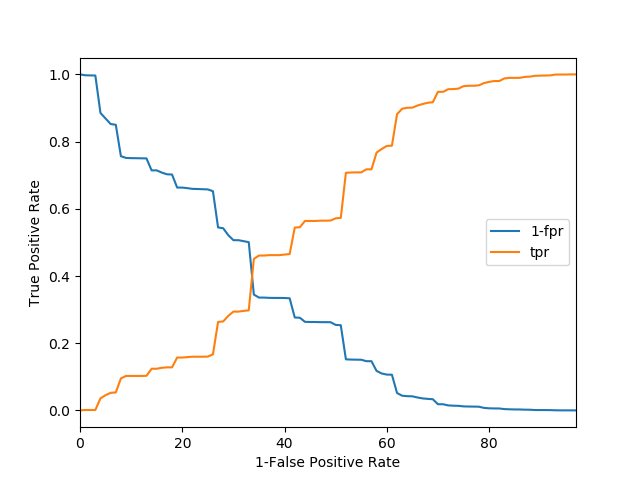

Text(0,0.5,'True Positive Rate')

In [288]:
fpr, tpr, thresholds =roc_curve(y_train, y_train_est_probs)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]
roc[['1-fpr','tpr']].plot()
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')

In [309]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y, y_pred=model.predict_proba(X)[:,0]>0.98)
cm

array([[25864,     0],
       [ 3227,     0]])

In [310]:
sum(cm.diagonal())/sum(cm.flatten())

0.88907222164930733

In [295]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y, y_pred=model.predict_proba(X)[:,0]>0.9))

             precision    recall  f1-score   support

          0       0.85      0.54      0.66     25864
          1       0.07      0.26      0.11      3227

avg / total       0.77      0.51      0.60     29091



[Python implementation reference](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8)